# **Amazon Review Clustering**
*Author: Ruchita Nagare*


In [242]:
import numpy as np
import pandas as pd
import gzip
from google.colab import files
import io

In [135]:
# !pip install ipython-autotime
# %load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.44 s (started: 2022-03-02 00:04:52 +00:00)


In [6]:
# uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


## Data Loading

Creating a Genearative function to load the data set using the yeild keyword.

In [179]:
def parse(path):
    g = gzip.open(path, 'rb' )
    for l in g:
        yield eval(l)

Taking 100k samples from the original dataset

In [180]:
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i == 100000:
            break;
        
    return pd.DataFrame.from_dict(df, orient='index')

In [181]:
true = True

false = False

In [46]:
# df = pd.read_csv(io.StringIO(uploaded['iris.csv'].decode('utf-8')))

Creating a dataframe

In [182]:
df = getDF('Colab Notebooks/data/Home_and_Kitchen.json.gz')

In [184]:
df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5.0,2,True,"08 31, 2010",A3NSN9WOX8470M,0006564224,mmm,"I don't use these for their original use, and in 1988 I purchased 2 and have needed replacements...",Many uses...,1283212800,NaN,NaN
1,5.0,2,True,"04 2, 2010",A2AMX0AJ2BUDNV,0006564224,John R. Welch,"Seems a bit expensive for a plastic bottle, but I couldn't find better value on the Internet. Pr...",Dispenser bottle,1270166400,NaN,NaN
2,5.0,NaN,True,"11 5, 2015",A8LUWTIPU9CZB,0560467893,Linda Fahner,"Great product, love it!!",Five Stars,1446681600,NaN,NaN
3,4.0,4,True,"10 29, 2015",AABKIIHAL0L66,0560467893,TheBlueChain,This is a sturdy floating corner shelf! We mounted a TV on the wall in the corner of the room a...,"Sturdy Shelf, Poor Installation Instructions",1446076800,NaN,NaN
4,3.0,NaN,True,"09 9, 2015",A3DA0KIQ5OBK5C,0560467893,angelaarden,I purchased 4 of these shelves. they look great. Thought they were wood. I guess I didn't read t...,Look great - one bad one...,1441756800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2.0,15,False,"10 20, 2006",A2I86D0I0NMRA5,B00004SBJO,lena,"I loved this dish, and have been using it for three months now. as with all LC cookware, one bec...",cracked in half at 450F...,1161302400,{'Color:': ' Citrus'},NaN
99996,5.0,NaN,False,"03 17, 2006",A2HNS5HO8O2BV4,B00004SBJO,anthrogeek,Very useful and very beautiful. Perfect for serving as well as cooking.,Lovely and functional,1142553600,{'Color:': ' Citrus'},NaN
99997,4.0,NaN,False,"04 6, 2008",A26SPBINAVFTE3,B00004SC51,Ronald L. Pagles,"works well easy clean up, lid does not set in place well for juice storage in ref tilts open pr...",black and decker juicer,1207440000,NaN,NaN
99998,5.0,NaN,False,"04 6, 2008",A25DJ7CZ9NYPNS,B00004SC51,James R. Baker,"This is a great product... I own a expensive Juicer,\n(BRAND NAME)Which is heavy , hard, to stor...",Black and decker cj525 juicer,1207440000,NaN,NaN


Removing rows with reviewText field as NA

In [185]:
df = df[df['reviewText'].notna()]

In [186]:
df.shape

(99978, 12)

We only need the reviewText column for the purpose of this assignment.

In [187]:
corpus = df['reviewText'].values

In [52]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Processing and Cleaning

Performing Tokeninzing and Lemmatization.

In [53]:
import nltk
from nltk.corpus import wordnet

# The WordNet Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Acceptable parts of speech
pos_map = {'N': wordnet.NOUN, 'J': wordnet.ADJ, 'V': wordnet.VERB, 'R': wordnet.ADV }

# Function to reduce corpus to word lemmas, limited to nouns, verbs, etc. 
def clean_corpus(corpus):
    cleaned = []
    for text in corpus:
        words = []
        text
        for sent in nltk.sent_tokenize(text):
            for (word, pos) in nltk.pos_tag(nltk.word_tokenize(sent)):
                if not pos[0] in pos_map:
                    continue
                word = lemmatizer.lemmatize(word.lower(), pos_map[pos[0]])
                words.append(word.lower())
#                 print(len(words))
        cleaned.append(words)
#         print(len(cleaned))
    return cleaned


In [54]:
clean_texts = clean_corpus(corpus)

In [55]:
len(clean_texts)

99978

Extracting the most frequent 30 words

In [56]:
from collections import Counter

# Print the 30 most frequent words, and add to stopword list
counter = Counter([w for t in clean_texts for w in t])
wordcounts = counter.most_common(n=30)
x = []
for word, count in wordcounts:
    x.append(word)
    print('%s%i' % (word.ljust(15), count))

be             181340
have           76548
use            48452
do             46101
not            33991
n't            32863
make           30384
great          28577
work           24996
very           24783
good           24239
get            23387
's             21464
so             20991
well           20132
buy            19566
just           19484
love           18909
time           18278
easy           18077
product        15596
up             15137
year           14555
more           12368
out            11987
clean          11679
only           11263
much           10283
little         10187
go             10119


Using the nltk stopwords and extending the list by appending most frequent 30 words.

In [57]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [243]:
len(stop_words)

209

Removing stopwords from each lemmatized text block

In [59]:
for i in range(len(clean_texts)):
    j = 0
    while j < len(clean_texts[i]):
        if clean_texts[i][j] in stop_words:
            del clean_texts[i][j]
        else:
            j += 1

In [60]:
# Show example text block after data preparation
print(clean_texts[0])

['original', 'purchase', 'need', 'replacement', 'last', 'never', 'even', 'think', 'internet', 'find', 'new', 'one', 'pleasant', 'surprise', 'find', 'immediately', 'actually', 'pay', 'le']


In [61]:
len(clean_texts[0])

19

## LDA Model Building

Preparing the dictionary and corpus

In [62]:
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
dictionaryAML = Dictionary(clean_texts)
corpusAML = [dictionaryAML.doc2bow(text) for text in clean_texts]

In [63]:
# View
print(corpusAML[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


Base Model

In [64]:
from gensim.models.ldamulticore import LdaMulticore

# Pretrain the model using the corpus and number of topics  
num_topicsAML = 20
ldaAML = LdaMulticore(corpusAML, id2word=dictionaryAML, num_topics=num_topicsAML, passes=2)

In [65]:
# Classify the first corpus using the pretrained model
result = ldaAML[corpusAML[0]]
print(result)

[(10, 0.12579967), (14, 0.8292003)]


Print the top 10 words in each learned topic

In [66]:
for i in range(num_topicsAML):
    print('Topic %i: %s\n' % (i, ldaAML.print_topic(i, topn=10)))

Topic 0: 0.042*"processor" + 0.039*"blade" + 0.030*"food" + 0.029*"kitchen" + 0.017*"tool" + 0.017*"nutmeg" + 0.017*"grate" + 0.016*"cheese" + 0.015*"sharp" + 0.015*"grater"

Topic 1: 0.102*"best" + 0.063*"gift" + 0.061*"ever" + 0.027*"'ve" + 0.026*"christmas" + 0.024*"daughter" + 0.022*"give" + 0.020*"friend" + 0.018*"purchase" + 0.017*"popcorn"

Topic 2: 0.032*"cup" + 0.028*"water" + 0.023*"pot" + 0.012*"coffee" + 0.011*"top" + 0.010*"heat" + 0.010*"hot" + 0.010*"put" + 0.010*"stove" + 0.009*"taste"

Topic 3: 0.020*"star" + 0.019*"plastic" + 0.014*"give" + 0.014*"design" + 0.013*"motor" + 0.008*"metal" + 0.008*"reason" + 0.008*"think" + 0.008*"need" + 0.007*"mold"

Topic 4: 0.058*"pressure" + 0.054*"canner" + 0.048*"rice" + 0.045*"cooker" + 0.033*"cook" + 0.013*"canning" + 0.011*"cupcake" + 0.011*"gasket" + 0.011*"cooking" + 0.010*"instruction"

Topic 5: 0.072*"price" + 0.065*"ice" + 0.062*"nice" + 0.026*"look" + 0.021*"really" + 0.020*"crush" + 0.016*"quality" + 0.015*"color" + 0.01

Calculating the coherence metric

In [67]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_ldaAML = CoherenceModel(model=ldaAML, texts=clean_texts, dictionary=dictionaryAML, coherence='c_v')
coherence_lda_AML = coherence_model_ldaAML.get_coherence()
print('Coherence Score: ', coherence_lda_AML)

Coherence Score:  0.4651227967628973


In [151]:
pickle.dump(ldaAML, open('ldaAML.model', 'wb'))

Trying models with different number of 'k' (topics)

Model 2 (10 topics)

In [68]:
num_topics2 = 10
lda2 = LdaMulticore(corpusAML, id2word=dictionaryAML, num_topics=num_topics2, passes=2)

In [69]:
for i in range(num_topics2):
    print('Topic %i: %s\n' % (i, lda2.print_topic(i, topn=10)))

Topic 0: 0.028*"iron" + 0.022*"bottle" + 0.016*"chopper" + 0.015*"wine" + 0.014*"popper" + 0.013*"corkscrew" + 0.012*"war" + 0.011*"cork" + 0.011*"pop" + 0.009*"expresso"

Topic 1: 0.020*"water" + 0.019*"pressure" + 0.016*"rice" + 0.016*"pot" + 0.016*"cooker" + 0.013*"lid" + 0.010*"top" + 0.009*"cook" + 0.009*"hot" + 0.009*"kettle"

Topic 2: 0.029*"canner" + 0.016*"small" + 0.013*"large" + 0.013*"hold" + 0.012*"jar" + 0.010*"fit" + 0.010*"handle" + 0.009*"holder" + 0.009*"size" + 0.008*"need"

Topic 3: 0.050*"pan" + 0.030*"bread" + 0.022*"perfect" + 0.020*"cake" + 0.019*"oven" + 0.017*"bake" + 0.012*"size" + 0.010*"look" + 0.010*"cupcake" + 0.010*"stick"

Topic 4: 0.021*"purchase" + 0.015*"new" + 0.015*"espresso" + 0.014*"order" + 0.013*"amazon" + 0.012*"gift" + 0.012*"old" + 0.012*"item" + 0.012*"look" + 0.011*"find"

Topic 5: 0.025*"button" + 0.016*"bag" + 0.015*"keep" + 0.015*"store" + 0.012*"lock" + 0.011*"container" + 0.009*"fit" + 0.009*"storage" + 0.009*"old" + 0.008*"nice"

Top

Topic 0 Wine: 0.028*"iron" + 0.022*"bottle" + 0.016*"chopper" + 0.015*"wine" + 0.014*"popper" + 0.013*"corkscrew" + 0.012*"war" + 0.011*"cork" + 0.011*"pop" + 0.009*"expresso"

Topic 1 Hot cooking: 0.020*"water" + 0.019*"pressure" + 0.016*"rice" + 0.016*"pot" + 0.016*"cooker" + 0.013*"lid" + 0.010*"top" + 0.009*"cook" + 0.009*"hot" + 0.009*"kettle"

Topic 2 Size/fit (of cans): 0.029*"canner" + 0.016*"small" + 0.013*"large" + 0.013*"hold" + 0.012*"jar" + 0.010*"fit" + 0.010*"handle" + 0.009*"holder" + 0.009*"size" + 0.008*"need"

Topic 3 Baking: 0.050*"pan" + 0.030*"bread" + 0.022*"perfect" + 0.020*"cake" + 0.019*"oven" + 0.017*"bake" + 0.012*"size" + 0.010*"look" + 0.010*"cupcake" + 0.010*"stick"

Topic 4 Purchase/Order: 0.021*"purchase" + 0.015*"new" + 0.015*"espresso" + 0.014*"order" + 0.013*"amazon" + 0.012*"gift" + 0.012*"old" + 0.012*"item" + 0.012*"look" + 0.011*"find"

Topic 5 Storage: 0.025*"button" + 0.016*"bag" + 0.015*"keep" + 0.015*"store" + 0.012*"lock" + 0.011*"container" + 0.009*"fit" + 0.009*"storage" + 0.009*"old" + 0.008*"nice"

Topic 6 Relevance of time with purchase: 0.015*"plastic" + 0.012*"break" + 0.010*"tea" + 0.010*"motor" + 0.009*"month" + 0.009*"last" + 0.008*"unit" + 0.008*"thing" + 0.008*"piece" + 0.007*"first"

Topic 7 Blending/Juices: 0.031*"blender" + 0.021*"food" + 0.019*"kitchen" + 0.016*"recommend" + 0.015*"processor" + 0.012*"quality" + 0.011*"cook" + 0.011*"fruit" + 0.010*"smoothy" + 0.009*"best"

Topic 8 Machines: 0.049*"coffee" + 0.020*"cup" + 0.019*"blender" + 0.014*"timer" + 0.012*"maker" + 0.011*"machine" + 0.011*"review" + 0.011*"grind" + 0.009*"cuisinart" + 0.009*"say"

Topic 9 Sharpness: 0.055*"blade" + 0.029*"knife" + 0.025*"ice" + 0.016*"cut" + 0.016*"sharp" + 0.010*"blender" + 0.009*"edge" + 0.009*"frozen" + 0.008*"whisk" + 0.008*"blend"



In [70]:
coherence_model_lda2 = CoherenceModel(model=lda2, texts=clean_texts, dictionary=dictionaryAML, coherence='c_v')
coherence_lda_2 = coherence_model_lda2.get_coherence()
print('Coherence Score: ', coherence_lda_2)

Coherence Score:  0.5044103518818458


*Here we can infer that by reducing the number of topics, the model performance increased*

## Saving this model for final consideration (Model Candidate 1)



In [241]:
import pickle

pickle.dump(lda2, open('topic.model', 'wb'))

Model 3 (7 topics)

In [71]:
num_topics3 = 7
lda3 = LdaMulticore(corpusAML, id2word=dictionaryAML, num_topics=num_topics3, passes=2)

In [72]:
for i in range(num_topics3):
    print('Topic %i: %s\n' % (i, lda3.print_topic(i, topn=10)))

Topic 0: 0.018*"coffee" + 0.013*"water" + 0.013*"cup" + 0.010*"pan" + 0.009*"lid" + 0.009*"pot" + 0.008*"tea" + 0.008*"hot" + 0.008*"top" + 0.007*"bottom"

Topic 1: 0.020*"blender" + 0.010*"review" + 0.009*"purchase" + 0.008*"last" + 0.008*"break" + 0.008*"first" + 0.008*"month" + 0.007*"new" + 0.007*"look" + 0.007*"amazon"

Topic 2: 0.037*"knife" + 0.022*"juice" + 0.020*"bread" + 0.019*"fruit" + 0.017*"cake" + 0.014*"perfect" + 0.013*"orange" + 0.013*"slice" + 0.013*"blade" + 0.012*"cupcake"

Topic 3: 0.021*"pressure" + 0.020*"canner" + 0.017*"cooker" + 0.016*"cook" + 0.012*"recommend" + 0.011*"espresso" + 0.009*"perfect" + 0.009*"purchase" + 0.009*"quality" + 0.009*"gift"

Topic 4: 0.023*"best" + 0.019*"coffee" + 0.017*"juicer" + 0.015*"ever" + 0.014*"grind" + 0.012*"grinder" + 0.011*"timer" + 0.010*"braun" + 0.009*"'ve" + 0.009*"thing"

Topic 5: 0.017*"waring" + 0.015*"old" + 0.014*"nutmeg" + 0.011*"need" + 0.010*"machine" + 0.010*"bag" + 0.009*"powerful" + 0.009*"motor" + 0.009*"mo

In [73]:
coherence_model_lda3 = CoherenceModel(model=lda3, texts=clean_texts, dictionary=dictionaryAML, coherence='c_v')
coherence_lda_3 = coherence_model_lda3.get_coherence()
print('Coherence Score: ', coherence_lda_3)

Coherence Score:  0.4424559531592265


In [152]:
pickle.dump(lda3, open('lda3.model', 'wb'))

*It can be infered that the model performance decreased by futhers decreasing the number of 'k'*

Here it can be obeserved that model with 10 number of topics has the highest coherence. Therefore, lets try and hyperparameter tune this model

## Hyperparameter Tuning

In [74]:
# supporting function
def compute_coherence_values(a, b):
    
    lda_model_test = gensim.models.LdaMulticore(corpus=corpusAML,
                                           id2word=dictionaryAML,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=2,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda_test = CoherenceModel(model=lda_model_test, texts=clean_texts, dictionary=dictionaryAML, coherence='c_v')
    
    return coherence_model_lda_test.get_coherence()

In [75]:
# Testing differnet models out with differnet values of alpha and beta

import tqdm

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

Function to compute coherence metrics for each combination of hyperparameter and storing it a dataframefor futher refernce and analysis

(*This step is computationally expensive and took 3 hours. Unfortunately the notebook got diconnected sometime after the execution. I had taken screenshots after the cell was done executing. Thus screenshots of the result of this computation is appended in the word document.*)

In [175]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)))

    for a in alpha:
                # iterare through beta values
        for b in beta:
                    # get the coherence score for the given parameters
            cv = compute_coherence_values(a=a, b=b)
            # Save the model results
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/30 [01:36<?, ?it/s]
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)

100%|██████████| 30/30 [2:54:45<00:00, 344.73s/it]

FileNotFoundError: ignored

time: 2h 54min 46s (started: 2022-03-02 01:14:11 +00:00)


In [179]:
resultsdf = pd.DataFrame(model_results)
resultsdf

,Alpha,Beta,Coherence
0,0.01,0.01,0.442384
1,0.01,0.31,0.444740
2,0.01,0.61,0.500353
3,0.01,0.91,0.550466
4,0.01,symmetric,0.381147
5,0.31,0.01,0.469001
6,0.31,0.31,0.434076
7,0.31,0.61,0.514019
8,0.31,0.91,0.496363
9,0.31,symmetric,0.439067


time: 46.1 ms (started: 2022-03-02 04:12:10 +00:00)


### Building a model with best combination of hyperparameters

In [85]:
num_topics4 = 10
lda4 = LdaMulticore(corpusAML, 
                    id2word=dictionaryAML, 
                    num_topics=num_topics4, 
                    random_state=100,
                    chunksize=100,
                    passes=2,
                    alpha=0.01,
                    eta=0.91)

In [86]:
for i in range(num_topics4):
    print('Topic %i: %s\n' % (i, lda4.print_topic(i, topn=10)))

Topic 0: 0.043*"pitcher" + 0.043*"ice" + 0.033*"tea" + 0.027*"drink" + 0.016*"crush" + 0.012*"pour" + 0.009*"spout" + 0.008*"bottle" + 0.007*"hot" + 0.006*"shake"

Topic 1: 0.012*"*" + 0.012*"ca" + 0.008*"describe" + 0.005*"promise" + 0.004*"bound" + 0.004*"artichoke" + 0.003*"wm" + 0.003*"would" + 0.003*"headline" + 0.002*"it.."

Topic 2: 0.122*"canner" + 0.016*"pint" + 0.013*"quart" + 0.010*"canners" + 0.009*"pressure" + 0.007*"tomato" + 0.007*"canning" + 0.007*"presto" + 0.007*"all-american" + 0.005*"pickle"

Topic 3: 0.057*"blade" + 0.040*"juicer" + 0.035*"juice" + 0.026*"processor" + 0.023*"nutmeg" + 0.023*"fruit" + 0.021*"orange" + 0.017*"pulp" + 0.014*"cuisinart" + 0.014*"citrus"

Topic 4: 0.042*"bread" + 0.031*"pan" + 0.028*"oven" + 0.018*"creuset" + 0.013*"bake" + 0.013*"color" + 0.013*"toaster" + 0.012*"iron" + 0.011*"waffle" + 0.010*">"

Topic 5: 0.080*"coffee" + 0.061*"grinder" + 0.048*"grind" + 0.022*"bean" + 0.018*"maker" + 0.018*"ground" + 0.017*"cup" + 0.013*"pot" + 0.0

Topic Drinks: 0.043*"pitcher" + 0.043*"ice" + 0.033*"tea" + 0.027*"drink" + 0.016*"crush" + 0.012*"pour" + 0.009*"spout" + 0.008*"bottle" + 0.007*"hot" + 0.006*"shake"

Topic ??: 0.012*"*" + 0.012*"ca" + 0.008*"describe" + 0.005*"promise" + 0.004*"bound" + 0.004*"artichoke" + 0.003*"wm" + 0.003*"would" + 0.003*"headline" + 0.002*"it.."

Topic Cans: 0.122*"canner" + 0.016*"pint" + 0.013*"quart" + 0.010*"canners" + 0.009*"pressure" + 0.007*"tomato" + 0.007*"canning" + 0.007*"presto" + 0.007*"all-american" + 0.005*"pickle"

Topic Juice: 0.057*"blade" + 0.040*"juicer" + 0.035*"juice" + 0.026*"processor" + 0.023*"nutmeg" + 0.023*"fruit" + 0.021*"orange" + 0.017*"pulp" + 0.014*"cuisinart" + 0.014*"citrus"

Topic Bake: 0.042*"bread" + 0.031*"pan" + 0.028*"oven" + 0.018*"creuset" + 0.013*"bake" + 0.013*"color" + 0.013*"toaster" + 0.012*"iron" + 0.011*"waffle" + 0.010*">"

Topic Coffee: 0.080*"coffee" + 0.061*"grinder" + 0.048*"grind" + 0.022*"bean" + 0.018*"maker" + 0.018*"ground" + 0.017*"cup" + 0.013*"pot" + 0.011*"water" + 0.009*"filter"

Topic Wine/color: 0.004*"sanyo" + 0.004*"colour" + 0.003*"sitram" + 0.003*"peach" + 0.002*"corkscrew" + 0.002*"recomend" + 0.002*"winemaster" + 0.002*"peep" + 0.002*"organization" + 0.002*"carpet"

Topic ??: 0.008*"blender" + 0.007*"look" + 0.006*"'ve" + 0.006*"purchase" + 0.006*"also" + 0.005*"really" + 0.005*"need" + 0.005*"first" + 0.005*"come" + 0.005*"thing"

Topic WIne: 0.008*"got" + 0.007*"polder" + 0.004*"winemaster" + 0.004*"corkscrew" + 0.003*"vin" + 0.003*"vacu" + 0.002*"cat" + 0.002*"radio" + 0.002*"elegance" + 0.001*"fuse"

Topic Delivery/Shipping Service: 0.057*"excellent" + 0.016*"thank" + 0.011*"delivery" + 0.008*"cd" + 0.007*"fast" + 0.007*"thanks" + 0.006*"awesome" + 0.006*"shipping" + 0.004*"seller" + 0.004*"described"



In [87]:
coherence_model_lda4 = CoherenceModel(model=lda4, texts=clean_texts, dictionary=dictionaryAML, coherence='c_v')
coherence_lda_4 = coherence_model_lda4.get_coherence()
print('Coherence Score: ', coherence_lda_4)

Coherence Score:  0.5468240945877287


*Here we can observe the coherence metrics has increased*

## Saving this Model for final consideration ( Model candidate 2)

In [103]:
import pickle

pickle.dump(lda4, open('lda4.model', 'wb'))

## Visualizing Candidate Model 1

Reference - https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

 Wordcloud of Top 10 words in each topic

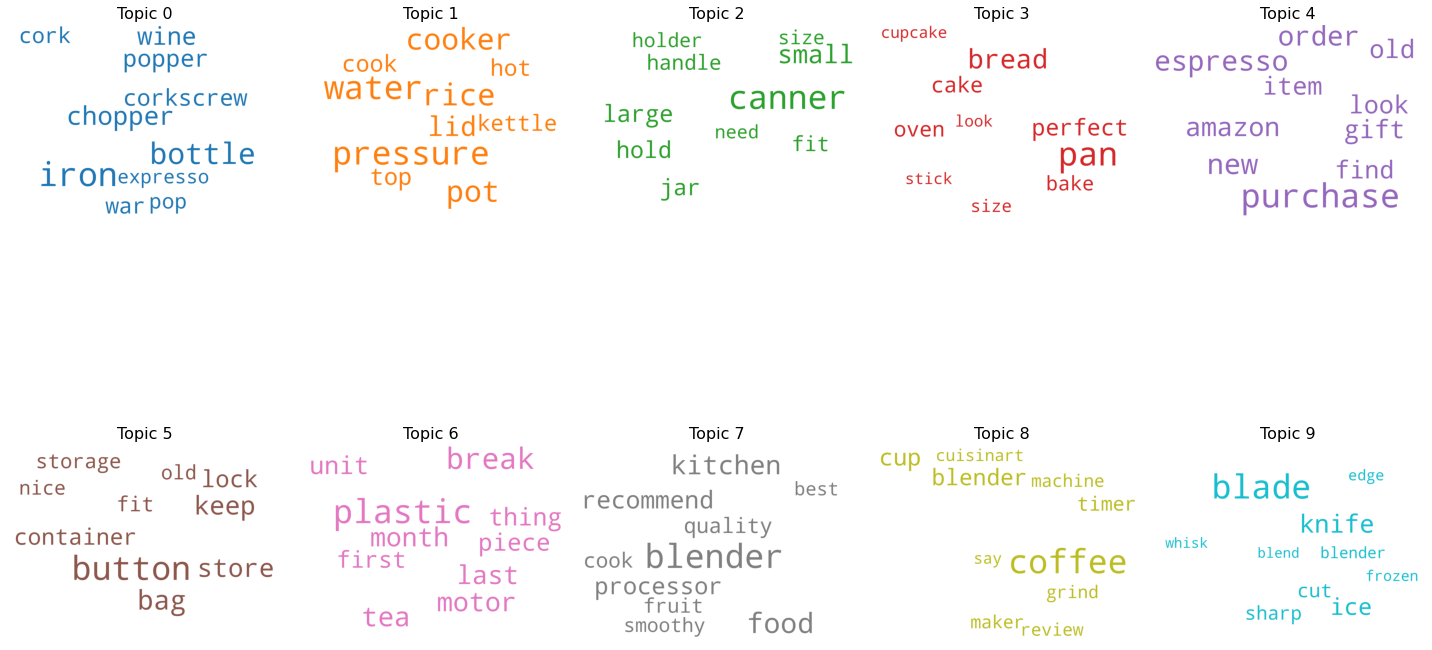

In [140]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word count of topic keywords for each topics

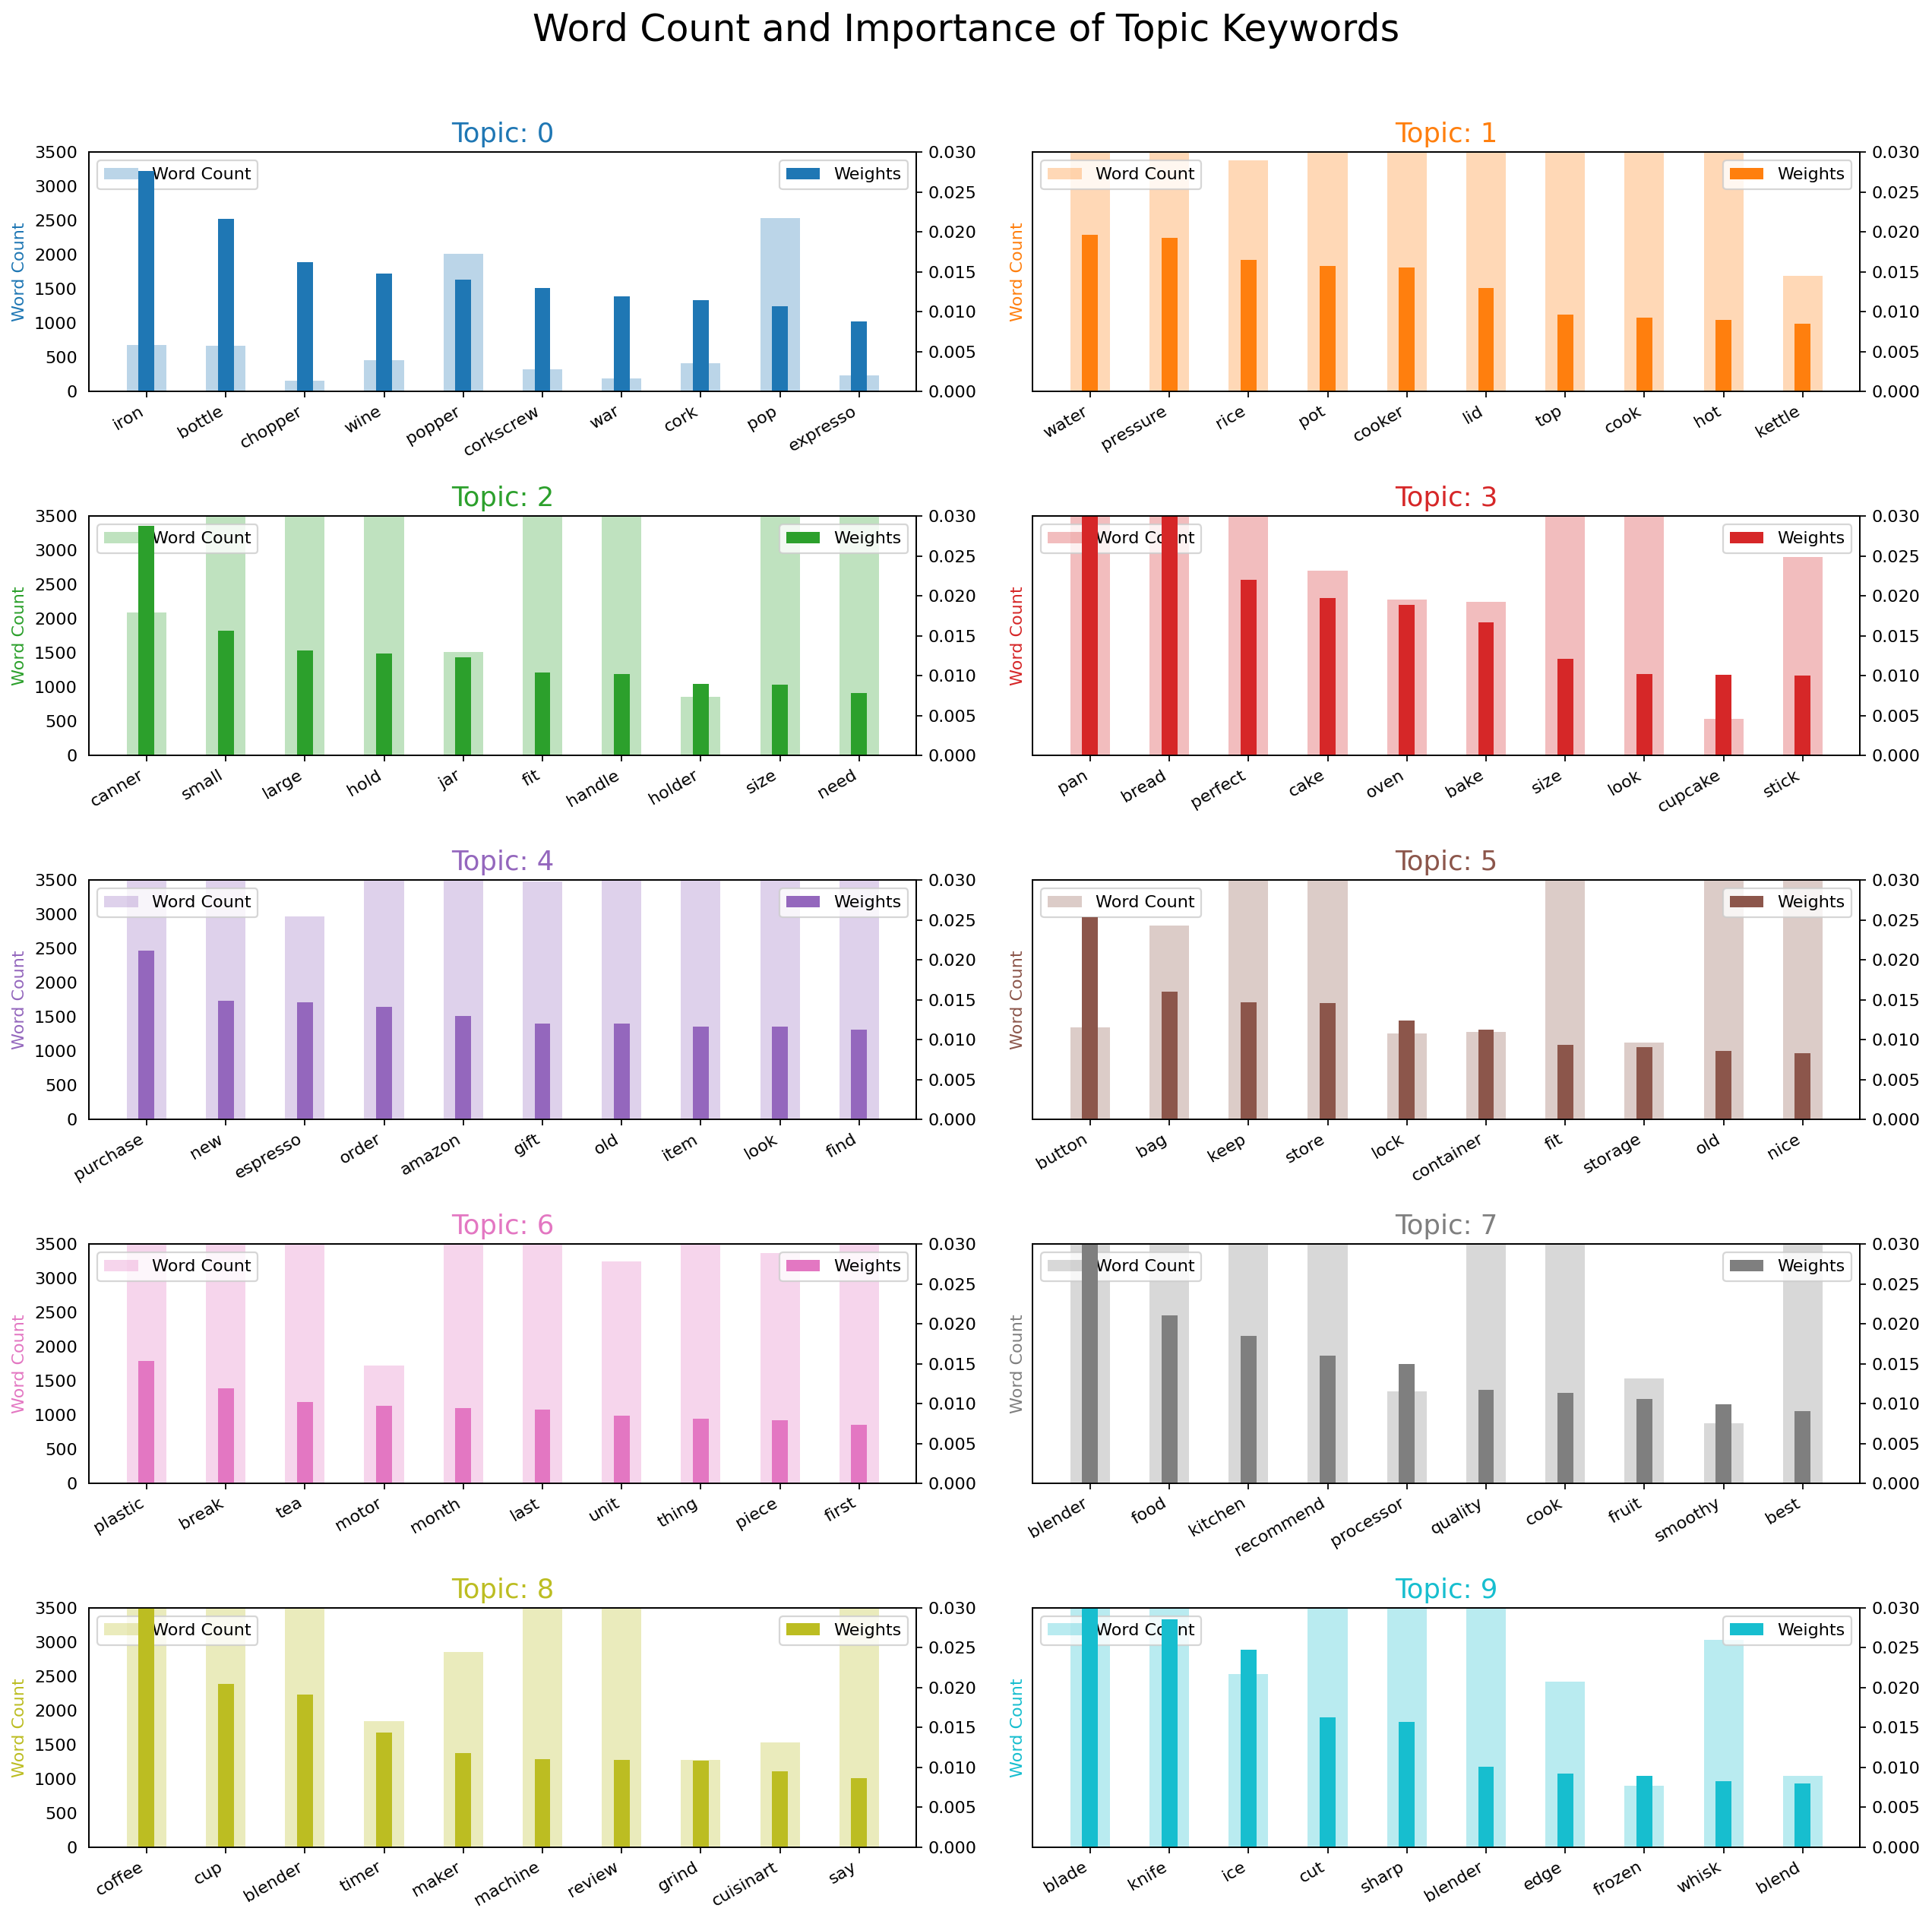

In [175]:
from collections import Counter
topics = lda2.show_topics(formatted=False)
data_flat = [w for w_list in clean_texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_lda2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_lda2.loc[df_lda2.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_lda2.loc[df_lda2.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_lda2.loc[df_lda2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [176]:
df_lda2

,word,topic_id,importance,word_count
0,iron,0,0.027697,687
1,bottle,0,0.021635,665
2,chopper,0,0.016193,160
3,wine,0,0.014770,455
4,popper,0,0.014007,2013
...,...,...,...,...
95,blender,9,0.010113,4711
96,edge,9,0.009277,2427
97,frozen,9,0.008909,904
98,whisk,9,0.008261,3033


## Plotting Intertopic Distance Map and Word Frequency

Reference - https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

In [135]:
#!pip install pyLDAvis


import pyLDAvis.gensim_models
%matplotlib inline
import pyLDAvis
#import pyLDAvis.gensim
vis = pyLDAvis.gensim_models.prepare(topic_model=lda2, corpus=corpusAML, dictionary=dictionaryAML)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Visualizing Candidate Model 2

Wordcloud of Top 10 words in each topic

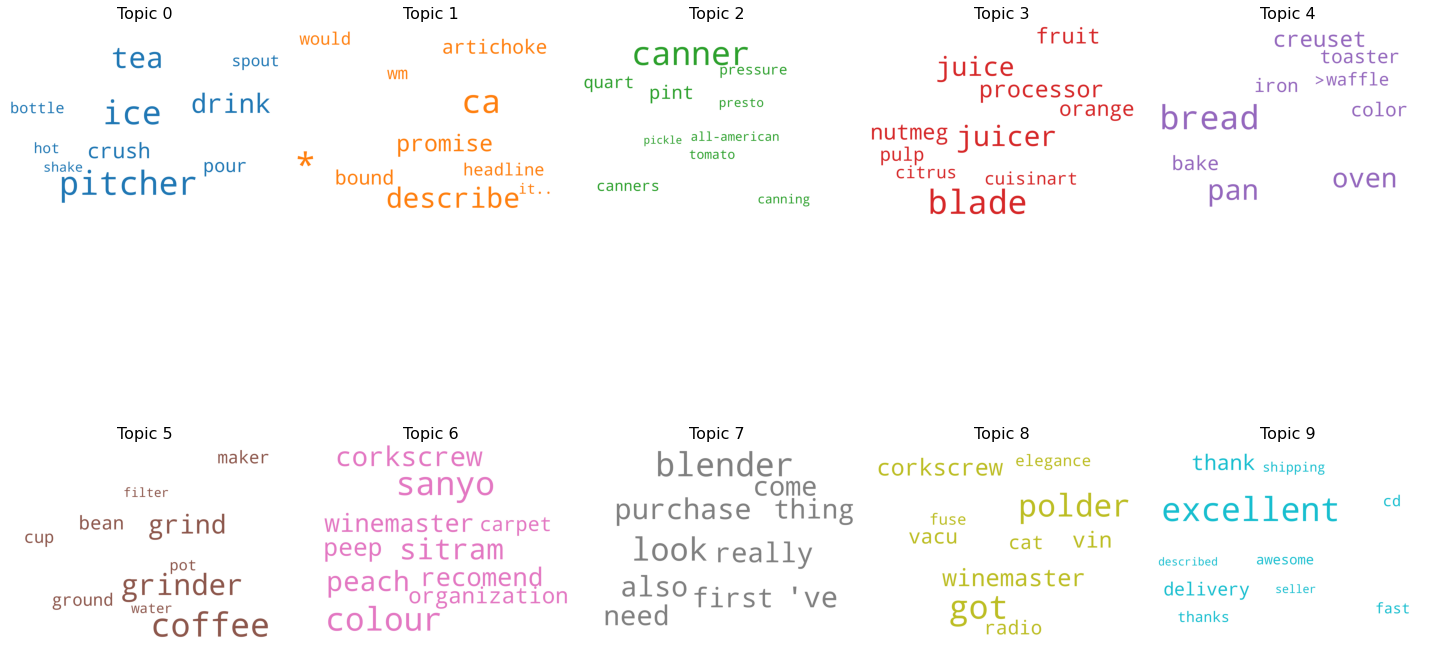

In [149]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Wordcloud of Top N words in each topic

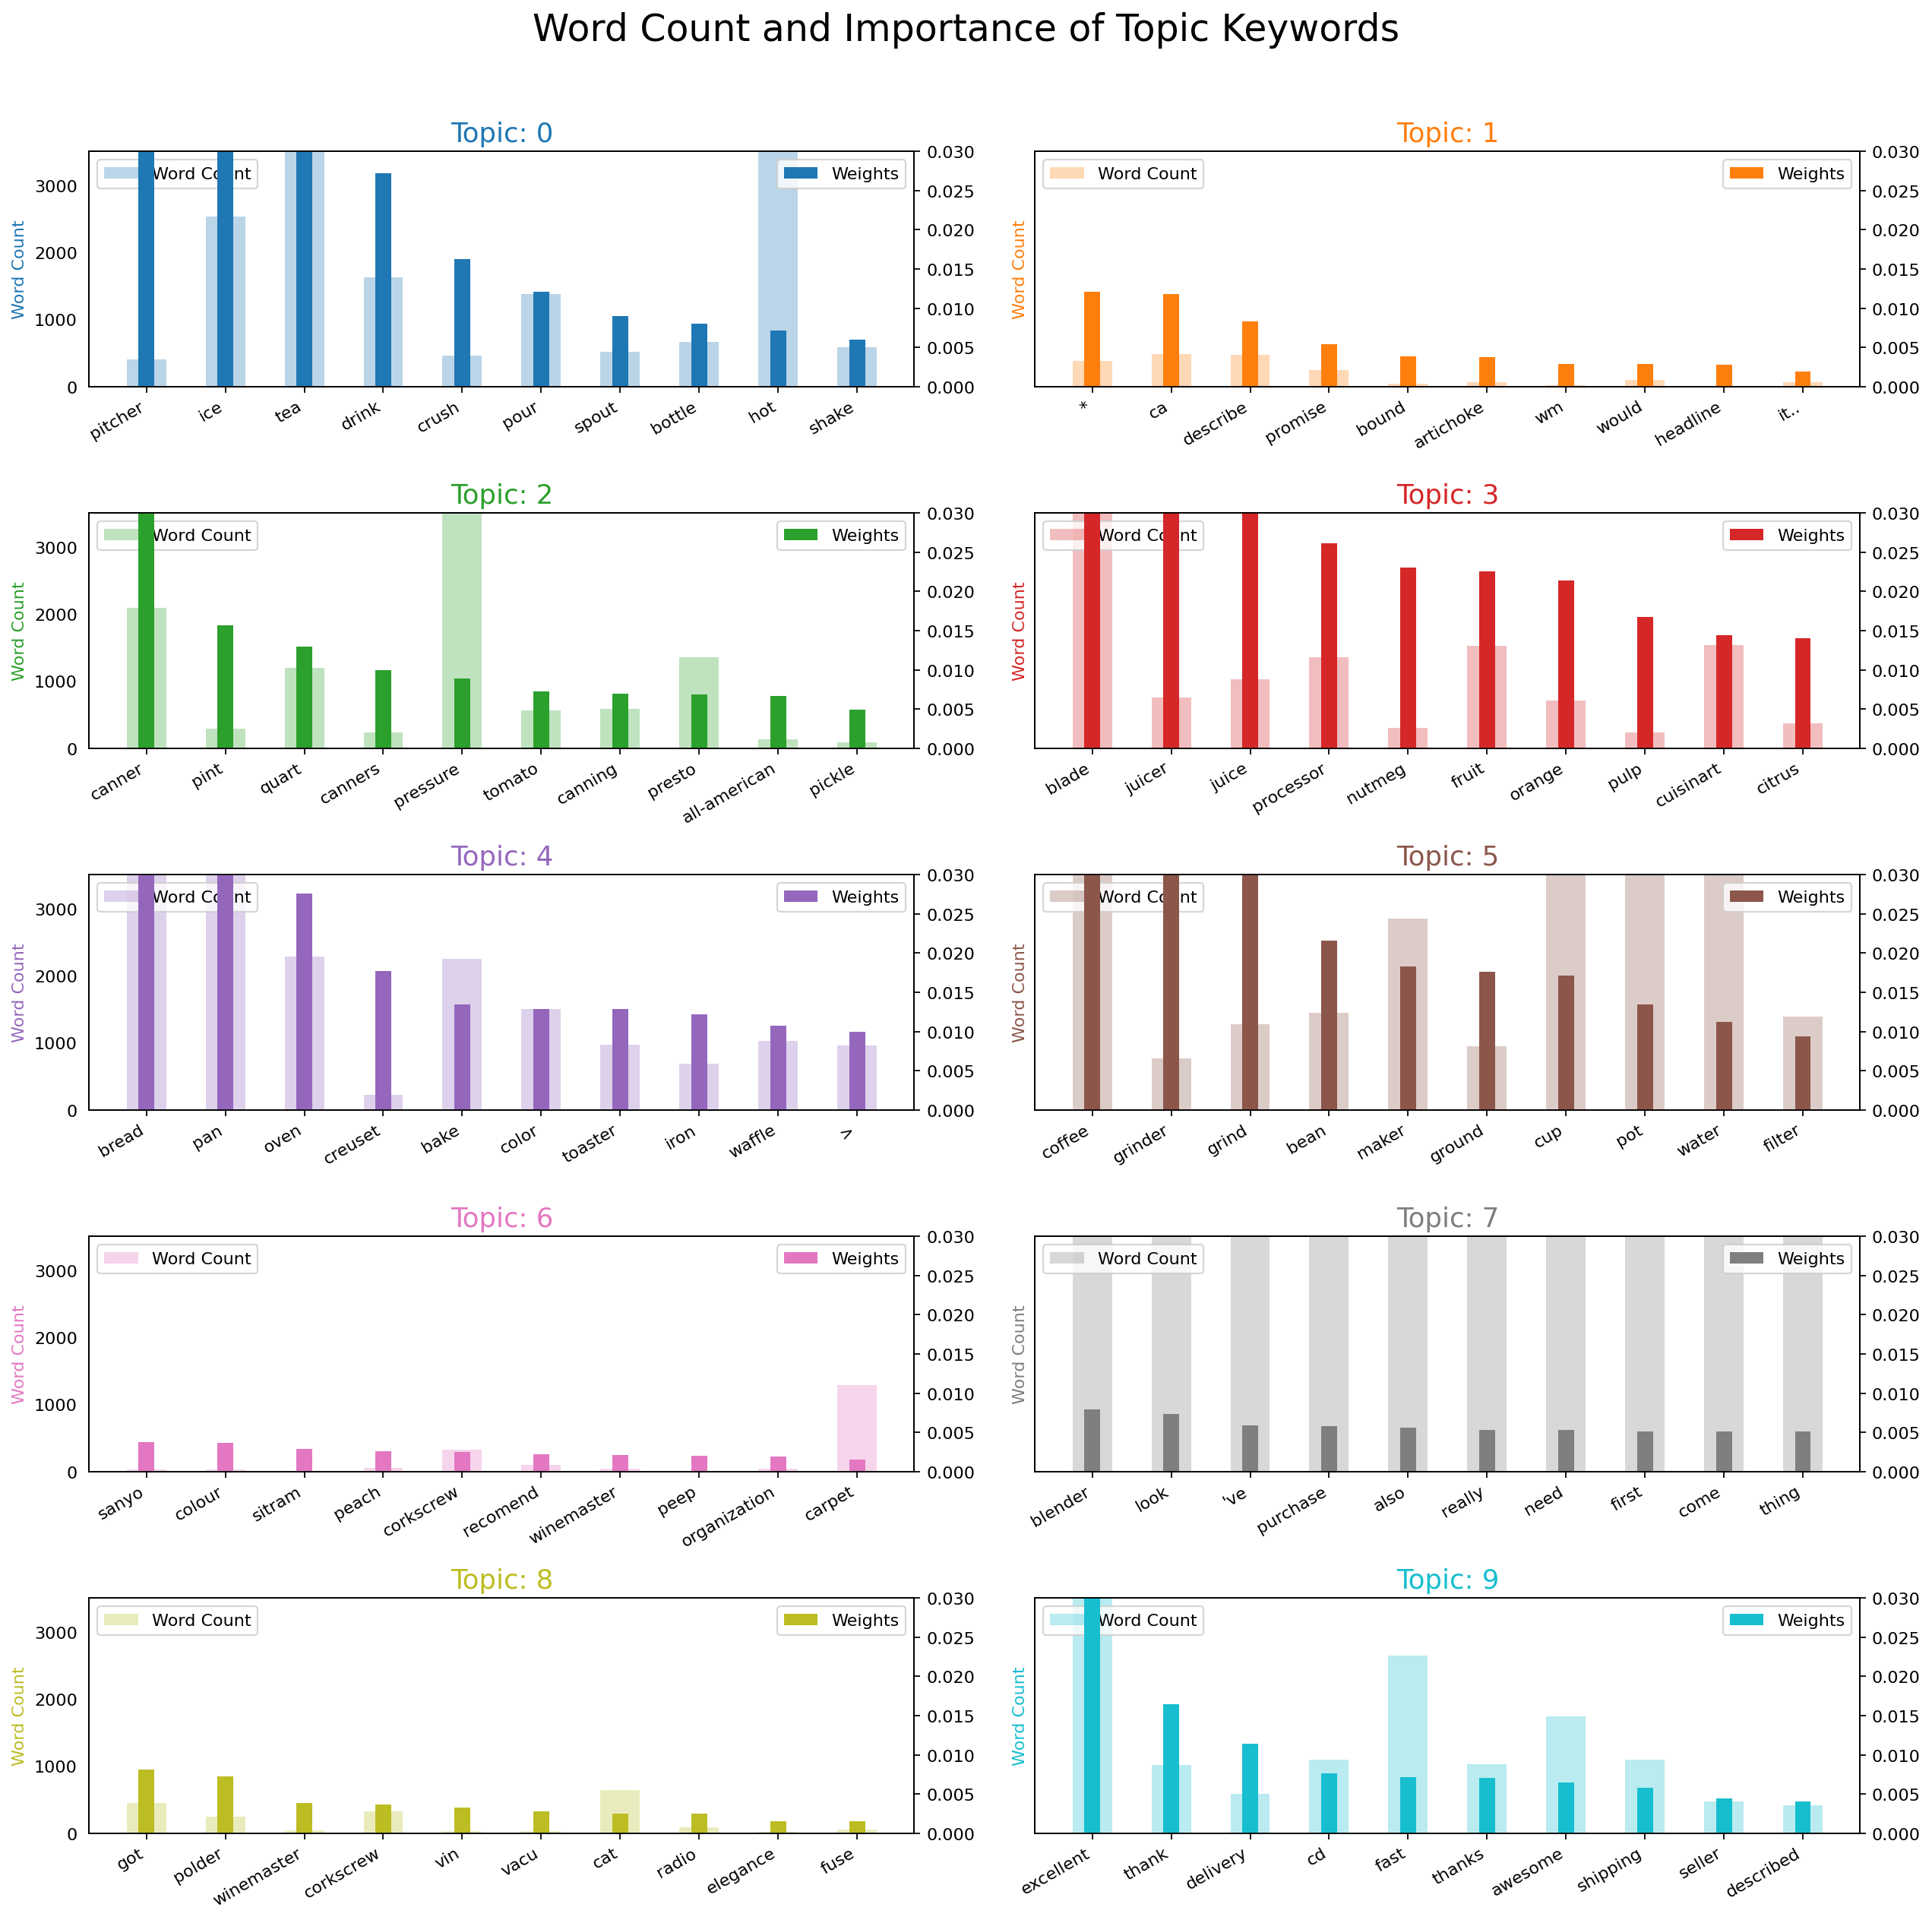

In [177]:
from collections import Counter
topics = lda4.show_topics(formatted=False)
data_flat = [w for w_list in clean_texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_lda4 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_lda4.loc[df_lda4.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_lda4.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_lda4.loc[df_lda4.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [178]:
df_lda4

,word,topic_id,importance,word_count
0,pitcher,0,0.043334,400
1,ice,0,0.042804,2536
2,tea,0,0.033414,4105
3,drink,0,0.027269,1627
4,crush,0,0.016274,460
...,...,...,...,...
95,thanks,9,0.007078,1021
96,awesome,9,0.006469,1743
97,shipping,9,0.005779,1096
98,seller,9,0.004403,468


## Plotting Intertopic Distance Map and Word Frequency

In [131]:

import pyLDAvis.gensim_models
%matplotlib inline
import pyLDAvis
#import pyLDAvis.gensim
vis = pyLDAvis.gensim_models.prepare(topic_model=lda4, corpus=corpusAML, dictionary=dictionaryAML)
pyLDAvis.enable_notebook()
pip install bertopicpyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### *We can observe that the intertopic distribution of candidate model 1 is more ditinct with less overlap, whereas for candidate model 2 it is less distinct and has more overlap, which could lead to mixed and less exclusive topics*

## ***Model Candidate 1 is our Winner***



## Reflecting upon some reviews to check if they denote the above modeled topics




In [169]:
get_document_topics = [lda2.get_document_topics(item) for item in corpusAML]

Let's handpick some random reviews and check if they lie within one of the topics

In [172]:
get_single_document_topics = lda2.get_document_topics(corpusAML[0])
get_single_document_topics

[(0, 0.09567248), (4, 0.86432105)]

The document is more probable of being in topic 4 (Purchase) Let's analyze the actual review text

In [189]:
df['reviewText'][0]

"I don't use these for their original use, and in 1988 I purchased 2 and have needed replacements for the last year.  I never even thought of using the Internet to find new ones but to my pleasant surprise I found them immediately and actually paid LESS for them than I did in 1988!"

*The above review majorly talks about purchasing and searching for products, just like the category of the topic*

In [205]:
get_second_document_topics = lda2.get_document_topics(corpusAML[4])
get_second_document_topics

[(1, 0.11639563), (2, 0.16884145), (4, 0.07251402), (6, 0.6255787)]

The document is more probable of being in topic 6(Relevance of time with purchase) Let's analyze the actual review text

In [244]:
df['reviewText'][4]

"I purchased 4 of these shelves. they look great. Thought they were wood. I guess I didn't read thoroughly. Anyway, that didn't matter to me, as they look real nice and were the size I was looking for. I gave them 3 stars as one of my shelves is coming apart at one end. I have used these less than 4 months. They all have way less than 30 lbs on them. It may be a minor issue and just a bad one as the others are great - no issues. My husband is going to try and glue and clamp it."

*The above review majorly talks about time of purchase and shelf life, just like the category of the topic*

In [236]:
get_third_document_topics = lda2.get_document_topics(corpusAML[10])
get_third_document_topics

[(0, 0.02546452),
 (1, 0.32298863),
 (2, 0.1391653),
 (3, 0.07065986),
 (4, 0.07252659),
 (6, 0.30610618),
 (9, 0.060629103)]

The document is more probable of being in topic 1( Hot cooking) topic 6(Relevance of time with purchase) Let's analyze the actual review text

In [238]:
df['reviewText'][10]

"This mug comes in a variety of colors most of which are hard to find on Amazon, easy to find on the seller's website but not easy to order. It's worth the effort of figuring out how to place the order though, as this mug keeps tea hot for a good couple of hours, and even longer if left in a sunny car. I have tried a variety of different travel mugs of similar size and this one is by far the best for not retaining the flavor of the previous cup of tea thanks to its metal instead of plastic interior. Additionally it is better designed, fitting nicely in the car cup-holder and having a flat lid that doesn't poke your nose every time you take a sip, and allows you to close the hole in the lid by sliding the cover with your teeth so you don't have to take both hands off the wheel while driving. The only minor quibble is that the sliding cover is a little hard to clean underneath (by hand, we don't use a dish-washer for anything) - this is not a problem for black or fruit teas, but if you t

*The above review majorly talks about both keeping tea hot and time of purchase and shelf life*